# Lecture 13: Transformers

Transformer-based language models are both ubiquitous and complex. On the one hand, I don't need to explain to you what they can do, since you probably use them already. On the other hand, unless you've already taken an NLP or ML course, you probably don't have a strong intuition or understanding about how transformers actually work.

It would take more than one lecture to explain the history of the transformer and how it came to revolutionize language modeling (not to mention its broader effects on human society). There is no shortage of videos and articles that will explain the transformer architecture better than I can, so we are going to go relatively light and the math and formalisms in this lecture.  

## Motivation
Let's start by thinking about some tradeoffs we've observed so far with different text encoding/representation methods:

| Method        | What does it represent? | Performance | Interpretability| Approach  | Cost |
|-----------|----------------------|-------------|---------------------|---------------|--|
| Count vectors | Documents        | +           | +++                 | Just count tokens | Super cheap |
| tf-idf | Documents | ++ | +++ | Count and weight tokens | Pretty cheap |
| PCA/SVD/LSA | Documents/words | +++ | ++ | Counts plus dim. reduction | Relatively cheap |
| LDA | Documents/topics | ++++ | +++ | Statistical modeling of topics w/ docs | Can take a while |
| word2vec | Words | ++++ | + | Predict word/context based on context/word | Pretty expensive |

The above table is massively over-simplifying things, but we can see that across all of these methods, there is always some tradeoff between performance, interpretability, and cost. Moreover, these methods actually model different things (documents, topics, or words) via different methods. 

So far, what all of these approaches have in common is that they operate either at the **word or document level, and do not necessarily model the complex linguistic relationships between tokens**. If I communicated this lecture to you, a human reader, as a single document vector of word counts, you would probably not be able to easily reconstruct the precise meaning of the lecture. Sure, you'd probably get a good topic-level impression of what I was talking about, but there'd be a ton of ambiguity. You'd probably have no idea how to characterize the style of the lecture, if there was any humor or wordplay, or even how the lecture was organized. And while an approach like word2vec might help you capture something about word-level meaning, it probably won't do any better at picking up these structural features either. 

## Language modeling 
If we want to capture all of this signal, we need to model language as a **sequence** of tokens. It's no longer sufficient to just throw all our words in a bag or construct a single representation for a word. Instead, we need to consider **how each token, in a given position, relates to the other tokens within a sequence**. In other words, what we need is a **language model**. At a high level, if we have a word 

$$p(w | context)$$

or, if we're just interested in the "left-context", 

$$p(w_{t+1}|w_0,...,w_{t})$$

So, given some preceding tokens $w_0,...,w_{t+1}$ , we want to know **a probability distribution over all the tokens in our vocabulary**. That is what today's language models learn to do. With transformers, this results not only in the ability to generate coherent text given some input (context), but also in a model that learns useful semantic representations, similar to word2vec but with generally much better performance. 

## Why the transformer? 
Transformers are the dominant architecture today, and they're what we're going to use throughout the rest of the course. The transformer architecture, along with hardware like GPUs, allows us to efficiently process the enormous amounts of data necessary to learn these conditional probabilities given long contexts. Preceding architectures like LSTMs (long short-term memory models) were **recurrent**, meaning that they processed data token-by-token, generating a representation of context as they moved through a sequence. This approach is much more human-like, but is difficult to parallelize. You don't need to know this history, but this all has some practical implications:
- Transformers have a fixed sequence length. They can only process sequences up to this maximimum length. If you pass multiple sequences to the model at the same time, they need to all be the exact same length, via padding shorter sequences and/or truncating longer sequences. 
- Transformers can "see" everything in a sequence unless you deliberately mask it out. They do not have a "memory" of prior tokens when they produce a probability distribution over their vocabulary. Obviously, this is not what humans do (you can't read an entire paragraph in parallel).
- Because of this, cost scales quadratically with sequence length. You will find that longer sequences take longer to process.
- Transformers are generally huge ("small" models have tens of millions of parameters, large models hundreds of billions). Training any decent transformer model from scratch, even a small one, is virtually impossible without significant computational and financial resources.
- As a result, the best transformer models are trained by a small number of labs, some of which (like OpenAI) do not publicly release model weights, relying on paid API usage and subscribers. For research, this can be a big problem. 
- Today's language models (think ChatGPT, Claude, Gemini, etc.) are not "pure" language models. They have been *pretrained* on unstructured text data, but undergo a significant amount of *supervised fine tuning* and *refinforcement learning* in order to get them to behave in a (hopefully) predictable and safe way. These are products, not scientific instruments, and as such they have biases and behavioral quirks that reflect the goals of their creators. 
- Transformers are very hard to interpret. It is generally not possible today to understand exactly *why* a model behaves the way it does. We'll talk about some emerging interpretability methods later in this course, but these are far from perfect. 


## A transformer layer in PyTorch
You won't need to ever build a transformer using PyTorch in this class, but the models you will work with are often built using transformer blocks similar to these. Let's take a look at what's inside the `TransformerDecoderLayer` module:

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
transformer = nn.TransformerDecoderLayer(
    d_model=128, 
    nhead=8, 
)

In [3]:
sum([p.numel() for p in transformer.parameters()])

659328

In [4]:
transformer

TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (linear1): Linear(in_features=128, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=128, bias=True)
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
)

Let's ignore the fact that this is a special type of transformer layer (a decoder). Let's focus just on what kinds of things we see inside this layer. We can see that there is
- Multi-head attention
- Linear layers
- Normalization 
- Dropout 

Of these, we've already seen `Linear` layers in MLPs. [`LayerNorm`](https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) performs a function similar to standardization, which we've covered previously, and [`Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html) just randomly sets some outputs to zero in order to reduce overfitting.

## Attention
`MultiheadAttention` is really the star of the show and is the mechanism that makes a transformer so powerful. Let's take a look at what `MultiheadAttention` is.

In [5]:
mha = nn.MultiheadAttention(
    embed_dim=5, 
    num_heads=1,
)

`MultiheadAttention` expects three inputs: 
- a Query tensor $Q$ with shape $(L, E)$, 
- a Key tensor $K$ with shape $(S, E)$, and  
- a Value tensor $V$ with shape $(S, E)$.

You should think of $L$ or $S$ here as the length of a sequence of embeddings, such as a sentence, where each embedding corresponds to a token in that sequence. This is different from what we've been doing before, where we have represented sequences with a single vector, or looked only at individual word embeddings. Normally, when processing language data, transformers represent each token in the sequence individually. This is part of what make them so powerful when compared to the lexical, document-level approaches we've been using up to this point! 

Attention, more specifically scaled dot-product attention, is computed like so for each head $i$: 

$$Q_i = QW_{i}^Q$$
$$K_i = KW_{i}^K$$
$$V_i = VW_{i}^V$$
$$Output_i = softmax(\frac{Q_iK_i^T}{\sqrt{d_h^k}})V_i$$
where $W$ s are learnable parameters (weights), $d_h^k$ is the embedding dimensionality of $K$ divided by the number of heads, and [$softmax$](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html) is a function that rescales inputs to lie in the range $[0, 1]$ and sum to 1. We get our final output by concatenating all the outputs of our different attention heads $i$. 

With language models, we're often considering the case where $Q = K = V$; in other words, we are performing scaled dot product *self-attention*. If each element of our sequence is an embedding corresponding to a single token, you can think of attention as a way of **determining how much each token in a sequence relates to all the other tokens in a sequence**.

Let's illustrate this in plain PyTorch. We're going to ignore the learnable parameters in all the $W$ matrices here, just focusing on a self-attention calculation for a single head.

In [6]:
Q = K = V = torch.tensor(
    [[1.0, 1.0, 0.2, 0.1, 0.0], 
     [0.2, 0.1, 0.0, 1.0, 1.0],
     [1.0, 0.9, 0.0, 0.1, 0.2],
     [0.1, 0.2, 1.0, 1.0, 0.7]
    ]
)

In the above tensor, we can see that the 0th and second embedding are quite similar, as are the first and third. Keep that in mind!

In [7]:
d_k = torch.tensor(K.size(1)).sqrt()                    # Square root of the embedding dim of K
attention_weights = F.softmax((Q @ K.t()) / d_k, dim=1) # Softmax of scaled dot product
attention_weights

tensor([[0.3401, 0.1626, 0.3195, 0.1778],
        [0.1666, 0.3485, 0.1814, 0.3034],
        [0.3258, 0.1806, 0.3186, 0.1750],
        [0.1664, 0.2770, 0.1605, 0.3961]])

<Axes: >

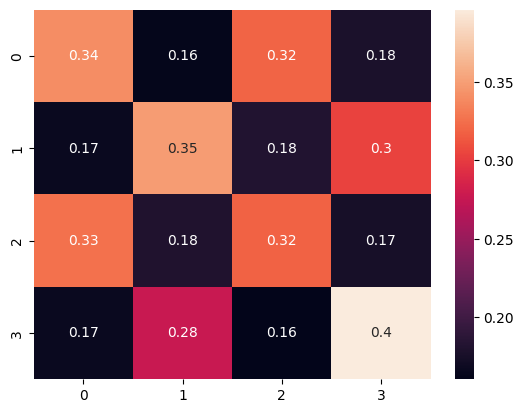

In [8]:
import seaborn as sns

sns.heatmap(
    attention_weights, annot=True
)

This checkerboard pattern reflects what we noted earlier about the alternating similarity between embeddings in our sequence. We can see that the 0th and 2nd embeddings are similar to one another, while the 1st and 3rd are also similar. At the same time, it also captures the shades of similarity and dissimilarity between all the elements of our sequence. 

Now, we use this attention matrix to weight the embeddings in our original sequence:

In [9]:
V_weighted = attention_weights @ V
V_weighted

tensor([[0.7099, 0.6794, 0.2458, 0.4064, 0.3510],
        [0.4481, 0.4254, 0.3367, 0.6868, 0.5972],
        [0.6981, 0.6656, 0.2402, 0.4200, 0.3668],
        [0.4219, 0.4177, 0.4294, 0.7058, 0.5864]])

In [10]:
# Compare to original embeddings:
V

tensor([[1.0000, 1.0000, 0.2000, 0.1000, 0.0000],
        [0.2000, 0.1000, 0.0000, 1.0000, 1.0000],
        [1.0000, 0.9000, 0.0000, 0.1000, 0.2000],
        [0.1000, 0.2000, 1.0000, 1.0000, 0.7000]])

Think for a second about what's really going on here in terms of the matrix multiplication. We are taking each row in the attention matrix and multiplying it by each column in the original, meaning that we are **modifying each original embedding based on all the other embeddings in the sequence**. In other words, **attention tells us how much each token in a sequence should "attend" to all the words in the sequence, then modifies its representation accordingly**. 

In reality, attention is more powerful than whhat we've shown above, since we weight our $Q$, $K$, and $V$ matrices with learnable parameters. You can see that the result of passing our `Q`, `K`, and `V` tensors to `MultiheadAttention` is not the same as what we computed, since each of these matrices is multiplied by a separate, learnable weight matrix prior to the attention calculation:

In [11]:
attn_output, attn_weights = mha(Q, K, V)

# Output of attention layer with random weights
attn_output

tensor([[ 0.2947, -0.0769, -0.3100,  0.3559, -0.0069],
        [ 0.3189, -0.0979, -0.3208,  0.3403, -0.0200],
        [ 0.2906, -0.0735, -0.3078,  0.3592, -0.0037],
        [ 0.3378, -0.1138, -0.3305,  0.3255, -0.0342]],
       grad_fn=<SqueezeBackward1>)

<Axes: >

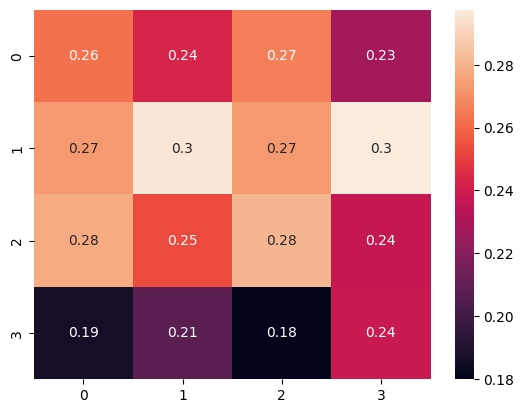

In [12]:
# Attention matrix with random weights
sns.heatmap(attn_weights.detach().t(), annot=True)

In [ ]:
print(f"Mean/std without weights:    {V_weighted.mean():.3f}  {V_weighted.std():.3f}")
print(f"Mean/std w/ random weights: {attn_output.mean():.3f}  {attn_output.std():.3f}")

Mean/std without weights:    0.492  0.158
Mean/std w/ random weights: 0.046  0.258


This is just to show that the learnable parameters (which, in `mha`, are currently just random values) have a big impact on the resulting attention calculation. 

## Moving forward
There's much more involved in a transformer than just attention, but the rest is best understood in the context of specific model architectures like BERT. We'll be going through that in discussion and subsequent lectures. 

Next week, we're going to look at how to use one of the original transformer language models. We'll describe in more detail how to use them to extract word- and sentence embeddings, as well as some of the quirks of using these models compared to the methods we've gone over already. 